In [3]:
import pandas as pd
import numpy as np
import os
os.listdir('../input')

['df_ref2_session.csv',
 'new_submission_dwell_time.csv',
 'new_submission_baseline.csv',
 'df_ref.csv',
 'df_dwell_time_session.csv',
 'ref_count2_baselineOnly_pred.csv',
 'train.csv',
 'df_ref2.csv',
 'submission_popular.csv',
 'item_metadata.csv',
 'df_full_except_noinfo.csv',
 'test.csv',
 'new_submission.csv',
 'dwell_df.csv',
 'baseline_sorting.csv',
 'dwell_time_agg.csv',
 'test2.csv']

In [94]:
path = '../input/'
df_dwell = pd.read_csv(path + 'df_dwell_time_session.csv')
df_dwell.reference = df_dwell.reference.apply(str)
df_dwell.dwell_time = df_dwell.dwell_time.apply(int)
df_dwell.head(3)

,session_id,reference,dwell_time
0,000056cd97ce2,3811810,23559
1,000056cd97ce2,2784325,28
2,00008c1f39c46,3501822,41422


In [95]:
df_dwell['dwell_min'] = df_dwell['dwell_time']/60

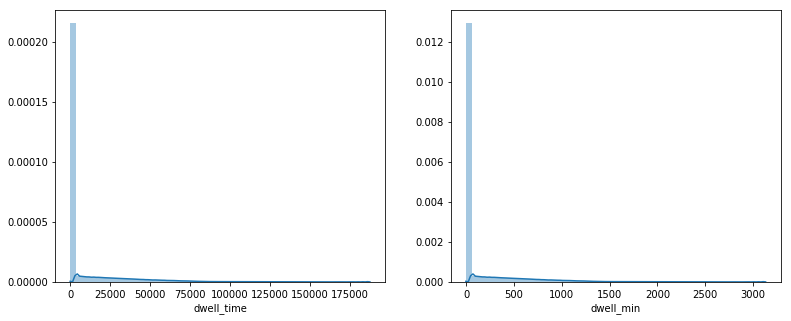

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols = 2, figsize = (13,5))
sns.distplot(df_dwell.dwell_time, ax = axs[0])
sns.distplot(df_dwell.dwell_min, ax = axs[1])

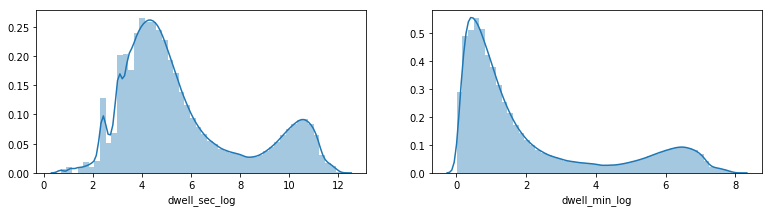

In [96]:
df_dwell['dwell_sec_log'] = np.log1p(df_dwell['dwell_time'])
df_dwell['dwell_min_log'] = np.log1p(df_dwell['dwell_min'])

fig, axs = plt.subplots(ncols = 2, figsize = (13,3))
sns.distplot(df_dwell.dwell_sec_log, ax = axs[0])
sns.distplot(df_dwell.dwell_min_log, ax = axs[1])

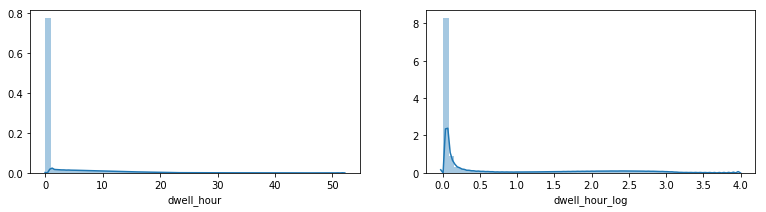

In [12]:
df_dwell['dwell_hour'] = df_dwell['dwell_min'] / 60
df_dwell['dwell_hour_log'] = np.log1p(df_dwell['dwell_hour'])

fig, axs = plt.subplots(ncols = 2, figsize = (13,3))
sns.distplot(df_dwell.dwell_hour, ax = axs[0])
sns.distplot(df_dwell.dwell_hour_log, ax = axs[1])

- dwell_min_log, dwell_sec_log

In [13]:
df_dwell.shape

(1943901, 8)

In [14]:
df_dwell.dwell_min_log.describe()

count    1.943901e+06
mean     2.066456e+00
std      2.121231e+00
min      1.652930e-02
25%      5.690945e-01
50%      1.120591e+00
75%      2.711378e+00
max      8.048447e+00
Name: dwell_min_log, dtype: float64

In [15]:
df_dwell.dwell_sec_log.describe()

count    1.943901e+06
mean     5.627356e+00
std      2.528926e+00
min      6.931472e-01
25%      3.850148e+00
50%      4.828314e+00
75%      6.738152e+00
max      1.214248e+01
Name: dwell_sec_log, dtype: float64

# data filtering

In [97]:
baseline_sub = pd.read_csv(path + 'new_submission.csv')
baseline_sub.impressions = baseline_sub.impressions.apply(lambda x : x.split('|'))
baseline_sub.reference = baseline_sub.reference.apply(str)
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [98]:
aa = df_dwell[df_dwell.session_id.isin(baseline_sub.session_id)]
aa = aa.groupby('session_id')['reference'].apply(lambda x : ' '.join(x)).to_frame().reset_index()
aa.reference = aa.reference.apply(lambda x : x.split(' '))
aa.columns = ['session_id', 'ref_list']
aa.head(3)

,session_id,ref_list
0,0000e0500c2e7,"[9387530, 3844380]"
1,000177b850519,"[17011, 17266]"
2,00017b3b2c136,"[6698142, 6298194]"


In [99]:
baseline_sub = pd.merge(baseline_sub, aa, how = 'left')
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions,ref_list
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10...","[3241426, 1050068, 2059240]"
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ...",NaN
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ...",[2817590]


In [32]:
def find_imp(imp, ref_list) :
    for ref in ref_list :
        if ref not in imp :
            ref_list.remove(ref)
            
    return ref_list

In [100]:
idx = baseline_sub[~baseline_sub.ref_list.isnull()].index
baseline_sub.loc[idx,'ref_list'] = baseline_sub.loc[idx].apply(lambda x : find_imp(x['impressions'], x['ref_list']), axis = 1)

In [104]:
baseline_sub.shape

(121526, 7)

In [101]:
s = baseline_sub.loc[idx].apply(lambda x: pd.Series(x['ref_list']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'item_id'
print(len(s))

214717


In [105]:
df_new = baseline_sub.loc[idx,['user_id', 'session_id']].join(s).reset_index(drop = True)
df_new.rename(columns = {'item_id' : 'reference'}, inplace = True)
print(df_new.shape)
df_new.head(3)

(217048, 3)


,user_id,session_id,reference
0,004A07DM0IDW,1d688ec168932,3241426
1,004A07DM0IDW,1d688ec168932,1050068
2,004A07DM0IDW,1d688ec168932,2059240


In [106]:
df_new = pd.merge(df_new, df_dwell[['session_id','reference','dwell_sec_log','dwell_min_log']])
df_new.head(3)

,user_id,session_id,reference,dwell_sec_log,dwell_min_log
0,004A07DM0IDW,1d688ec168932,3241426,9.888475,5.797121
1,004A07DM0IDW,1d688ec168932,1050068,4.574711,0.955511
2,004A07DM0IDW,1d688ec168932,2059240,4.418841,0.861482


In [108]:
df_new.shape

(214717, 5)

# surprise

In [39]:
from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate, train_test_split
#from surprise import KNNBasic,KNNWithMeans,KNNWithZScore,KNNBaseline #memory error
from surprise import SVD, SVDpp
from surprise import BaselineOnly
from surprise.accuracy import rmse
from surprise import accuracy

# train_test_split

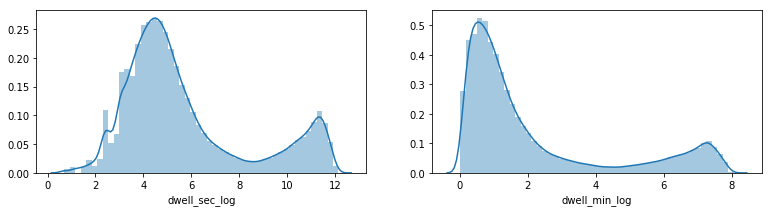

In [109]:
fig, axs = plt.subplots(ncols = 2, figsize = (13,3))
sns.distplot(df_new.dwell_sec_log, ax = axs[0])
sns.distplot(df_new.dwell_min_log, ax = axs[1])

In [110]:
print('sec_log min : {}, sec_log max : {}'.format(df_new.dwell_sec_log.min(), df_new.dwell_sec_log.max()))
print('min_log min : {}, sec_log max : {}'.format(df_new.dwell_min_log.min(), df_new.dwell_min_log.max()))

sec_log min : 0.6931471805599453, sec_log max : 12.142477679104815
min_log min : 0.016529301951210565, sec_log max : 8.04844743738033


In [111]:
df_new.reference = df_new.reference.apply(int)

#dwell_sec_log
reader = Reader(rating_scale=(0,12.5))
data1 = Dataset.load_from_df(df_new[['session_id','reference','dwell_sec_log']], reader)

#dwell_min_log
reader = Reader(rating_scale=(0,8))
data2 = Dataset.load_from_df(df_new[['session_id','reference','dwell_min_log']], reader)

# data1

In [112]:
trainset,testset = train_test_split(data1, test_size = 0.3)

In [118]:
#SVD
algo = SVD(lr_all = 0.005, n_epochs = 10)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

RMSE: 2.6106


2.610587078690353

In [121]:
#SVDpp
algo = SVDpp(lr_all = 0.005, n_epochs = 10)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

RMSE: 2.6097


2.6096679900952373

In [115]:
#BaselineOnly
bsl_options = {'method' : 'als',
              'n_epochs' : 10,
              'reg_u' : 30,
              'reg_i' : 30}

algo = BaselineOnly(bsl_options=bsl_options)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

Estimating biases using als...
RMSE: 2.6115


2.611540247680059

In [126]:
baseline_sub = pd.read_csv(path + 'new_submission.csv')
baseline_sub.impressions = baseline_sub.impressions.apply(lambda x : x.split('|'))
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [127]:
algo = SVDpp(lr_all = 0.005, n_epochs = 10)

trainset = data1.build_full_trainset()
fitting = algo.fit(trainset)

In [129]:
item_unique = df_new.reference.unique().astype(np.int)
session_unique = df_new.session_id.unique()

print('session id : ',len(session_unique))
print('item id : ',len(item_unique))

session id :  88380
item id :  100963


In [132]:
pred = []
pred_df = pd.DataFrame(columns = ['uid','iid','est'])

i = 0
for sess in session_unique :
    i+=1
    if i%10000 == 0 :
        print('{}번째 id'.format(i))
        if len(pred) > 0 :
            pred = pd.DataFrame(pred)[['uid','iid','est']]
            pred_df = pred_df.append(pred)
            pred_df.to_csv(path + 'dwell_sec_log_SVDpp_pred.csv', index = False)
            pred = []
    
    iid = baseline_sub[baseline_sub.session_id == sess]['impressions'].values[0]
    iid = list(map(int, iid))

    for item in iid :
        if item in item_unique :
            algo_pred = algo.predict(sess, item)
            pred.append(algo_pred)

10000번째 id
20000번째 id
30000번째 id
40000번째 id
50000번째 id
60000번째 id
70000번째 id
80000번째 id


# data2

In [133]:
trainset,testset = train_test_split(data2, test_size = 0.3)

In [134]:
#SVD
algo = SVD(lr_all = 0.005, n_epochs = 10)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

RMSE: 2.2347


2.23469305751957

In [135]:
#SVDpp
algo = SVDpp(lr_all = 0.005, n_epochs = 10)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

RMSE: 2.2337


2.233664943338594

In [136]:
#BaselineOnly
bsl_options = {'method' : 'als',
              'n_epochs' : 10,
              'reg_u' : 30,
              'reg_i' : 30}

algo = BaselineOnly(bsl_options=bsl_options)

pred = algo.fit(trainset).test(testset)
accuracy.rmse(pred)

Estimating biases using als...
RMSE: 2.2332


2.2331770699575793

In [146]:
baseline_sub = pd.read_csv(path + 'new_submission.csv')
baseline_sub.impressions = baseline_sub.impressions.apply(lambda x : x.split('|'))
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [147]:
algo = BaselineOnly(bsl_options=bsl_options)

trainset = data1.build_full_trainset()
fitting = algo.fit(trainset)

Estimating biases using als...


In [148]:
pred = []
pred_df = pd.DataFrame(columns = ['uid','iid','est'])

i = 0
for sess in session_unique :
    i+=1
    if i%10000 == 0 :
        print('{}번째 id'.format(i))
        if len(pred) > 0 :
            pred = pd.DataFrame(pred)[['uid','iid','est']]
            pred_df = pred_df.append(pred)
            pred_df.to_csv(path + 'dwell_min_log_bol_pred.csv', index = False)
            pred = []
    
    iid = baseline_sub[baseline_sub.session_id == sess]['impressions'].values[0]
    iid = list(map(int, iid))

    for item in iid :
        if item in item_unique :
            algo_pred = algo.predict(sess, item)
            pred.append(algo_pred)

10000번째 id
20000번째 id
30000번째 id
40000번째 id
50000번째 id
60000번째 id
70000번째 id
80000번째 id


# scoring

In [187]:
baseline_sub = pd.read_csv(path + 'new_submission.csv')
baseline_sub.impressions = baseline_sub.impressions.apply(lambda x : x.split('|'))
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ..."


In [154]:
sec_log = pd.read_csv(path + 'dwell_sec_log_SVDpp_pred.csv')
min_log = pd.read_csv(path + 'dwell_min_log_bol_pred.csv')

sec_log.columns = ['session_id', 'sec_iid', 'est']
min_log.columns = ['session_id', 'min_iid', 'est']

print('sec shape : ', sec_log.shape)
print('min shape : ', min_log.shape)

sec shape :  (1178338, 3)
min shape :  (1178338, 3)


In [155]:
sec_log = sec_log.groupby('session_id').apply(lambda x : x.sort_values(['est'], ascending = False)).reset_index(drop = True)
sec_log.sec_iid = sec_log.sec_iid.apply(str)

min_log = min_log.groupby('session_id').apply(lambda x : x.sort_values(['est'], ascending = False)).reset_index(drop = True)
min_log.min_iid = min_log.min_iid.apply(str)

In [157]:
sec_log = sec_log.groupby('session_id')['sec_iid'].apply(lambda x : ' '.join(x)).to_frame().reset_index()
sec_log.sec_iid = sec_log.sec_iid.apply(lambda x : x.split(' '))

min_log = min_log.groupby('session_id')['min_iid'].apply(lambda x : ' '.join(x)).to_frame().reset_index()
min_log.min_iid = min_log.min_iid.apply(lambda x : x.split(' '))

In [158]:
sec_log.head(3)

,session_id,sec_iid
0,0000e0500c2e7,"[9387530, 9377514, 6058504, 8709402, 6688304, ..."
1,000177b850519,"[2612598, 17578, 4897876, 17579, 153594, 17329..."
2,00017b3b2c136,"[6698142, 509856, 2565452, 4341718, 7952264, 2..."


In [159]:
min_log.head(3)

,session_id,min_iid
0,0000e0500c2e7,"[6058504, 9377514, 9387530, 8709402, 6826370, ..."
1,000177b850519,"[4897876, 17578, 17579, 2612598, 153594, 17329..."
2,00017b3b2c136,"[6698142, 509856, 2565452, 4341718, 7952264, 2..."


In [188]:
baseline_sub= pd.merge(baseline_sub, sec_log, how = 'left').merge(min_log, how = 'left')
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions,sec_iid,min_iid
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10...","[3241426, 4491766, 1472107, 4359818, 399441, 1...","[4491766, 1472107, 4359818, 3241426, 1167004, ..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ...",NaN,NaN
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ...","[2817590, 4016204, 3180004]","[2817590, 4016204, 3180004]"


In [182]:
def sort_again(imp, ref) :
    if type(ref) == float :
        return imp
    
    my = []
    imp2 = imp.copy()
    for rr in ref :
        if rr in imp :
            
            my.append(rr)
            imp2.remove(rr)
    imp2 = my + imp2
    return imp2

In [189]:
baseline_sub.reference = baseline_sub.reference.apply(str)

baseline_sub['impressions1'] = baseline_sub.apply(lambda x : sort_again(x['impressions'], x['sec_iid']), axis = 1)
baseline_sub['impressions2'] = baseline_sub.apply(lambda x : sort_again(x['impressions'], x['min_iid']), axis = 1)

In [193]:
baseline_sub.head(3)

,user_id,session_id,timestamp,step,reference,impressions,sec_iid,min_iid,impressions1,impressions2
0,004A07DM0IDW,1d688ec168932,1541555792,6,3241426,"[2059240, 2033381, 1724779, 127131, 399441, 10...","[3241426, 4491766, 1472107, 4359818, 399441, 1...","[4491766, 1472107, 4359818, 3241426, 1167004, ...","[3241426, 4491766, 1472107, 4359818, 399441, 1...","[4491766, 1472107, 4359818, 3241426, 1167004, ..."
1,00Y1Z24X8084,26b6d294d66e7,1541651766,1,3843244,"[2714480, 4476010, 3843244, 3833012, 9017890, ...",NaN,NaN,"[2714480, 4476010, 3843244, 3833012, 9017890, ...","[2714480, 4476010, 3843244, 3833012, 9017890, ..."
2,01V3WDTDM5CU,07628a0f5be0b,1541575516,4,2817590,"[3565720, 2947584, 4115018, 2039671, 3836538, ...","[2817590, 4016204, 3180004]","[2817590, 4016204, 3180004]","[2817590, 4016204, 3180004, 3565720, 2947584, ...","[2817590, 4016204, 3180004, 3565720, 2947584, ..."


In [195]:
def mrr(answer, imp) :
    myscore = 0
    
    for i,j in zip(answer, imp) :
        if i in j :
            myscore += 1/(j.index(i) + 1)
    print(myscore / len(imp))

In [196]:
baseline_sub.reference = baseline_sub.reference.apply(str)

In [198]:
#sec log
mrr(baseline_sub['reference'], baseline_sub['impressions1'])

0.47162371162130295


In [199]:
#min log
mrr(baseline_sub['reference'], baseline_sub['impressions2'])

0.4191939942005333
